# 機械学習の精度を上げる（パラメーターチューニング）

## 目次

 - ハイパーパラメーターとは？
 - グリッドサーチによるパラメーターサーチ
 - ベイズ最適化によるパラメーターサーチ
 - スタッキングによる精度向上

## ハイパーパラメーターとは?

「機械学習アルゴリズムにおいて、人が調整するべきパラメーターのこと」です。

例えば、ディープラーニングにおける、層の数などがパラメーターに相当します。

<img src="./assets/pic/deeplearning1.png" width="50%">

今回は、2種類の手法でハイパーパラメータを探索します。

①：グリッドサーチ（いくつかの値の全組み合わせを試し、最適な値を探す）

②：ベイズ最適化によるパラメーターサーチ

②の方が使用されていることは多いですが、両方試してみます。

## 探索範囲について

私が使用しているパラメーター探索範囲は以下です。[公式のリファレンス](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)も参照ください。

```python
all_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [3, 5, 10],
    'n_estimetors': [10000],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],
    'random_state': [0],
    'n_jobs': [1],
}
```

## グリッドサーチによるパラメーターサーチ

(`sklearn.model_selection.ParameterGrid`)[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html] に上記の辞書を与えると、全通りのパラメーターを作ってくれます。

以下は検証用のミニコード。

 - ソースコード


In [1]:
from sklearn.model_selection import ParameterGrid
all_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [3, 5, 10],
    'n_estimetors': [10000],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],
    'random_state': [0],
    'n_jobs': [1],
}

for params in ParameterGrid(all_params):
    print(params)
    break # ここコメントアウトすると全部のパラメーターが出力されていることがわかります。

{'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimetors': 10000, 'n_jobs': 1, 'random_state': 0, 'reg_alpha': 0}


実際のソースコードで試してみます。

 - ソースコード

In [4]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# 組み合わせが多いので、進捗を可視化するツールを入れました。
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')

# all_paramsはグローバル変数として宣言
all_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [3, 5, 10],
    'n_estimetors': [10000],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],
    'random_state': [0],
    'n_jobs': [1],
}


def validate(train_x, train_y, params):
    accuracies = []
    feature_importances = []

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(train_x, train_y):
        trn_x = train_x.iloc[train_idx, :]
        val_x = train_x.iloc[test_idx, :]

        trn_y = train_y.iloc[train_idx]
        val_y = train_y.iloc[test_idx]

        clf = xgb.XGBClassifier(**params)
        clf.fit(trn_x, trn_y)

        pred_y = clf.predict(val_x)
        feature_importances.append(clf.feature_importances_)
        accuracies.append(accuracy_score(val_y, pred_y))
    print(np.mean(accuracies))
    return accuracies, feature_importances


def plot_feature_importances(feature_importances, cols):
    df_fimp = pd.DataFrame(feature_importances, columns=cols)
    df_fimp.plot(kind="box", rot=90)


def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df


# test dataのpredict
def predict_df(train_x, train_y, test_x, df_test_raw, path_output="result.csv"):
    params = {'learning_rate': 0.008306052798923729, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.8210307463506532, 'colsample_bylevel': 0.8061816543590015}
    clf = xgb.XGBClassifier(**params)
    clf.fit(train_x, train_y)
    preds = clf.predict(test_x)
    
    _df = pd.DataFrame()
    _df["PassengerId"] = df_test_raw["PassengerId"]
    _df["Survived"] = preds
    _df.to_csv(path_output, index=False)


def main():
    df_train = pd.read_csv("train.csv")

    # ここは前処理
    train_y = df_train["Survived"]
    train_x = df_train.drop("Survived", axis=1)

    train_x = preprocess_df(train_x)
    accuracies, feature_importances = validate(train_x, train_y, {})
    print(np.mean(accuracies))
    plot_feature_importances(feature_importances, train_x.columns)

    flag_product = True
    if flag_product:
        df_test = pd.read_csv("test.csv")
        df_test_raw = df_test.copy()
        test_x = preprocess_df(df_test)
        predict_df(train_x, train_y, test_x, df_test_raw, "result.csv")

# main文を書き換えているので、別関数として定義
def main_parametersearch():
    df_train = pd.read_csv("train.csv")
    train_y = df_train["Survived"]
    train_x = df_train.drop("Survived", axis=1)
    train_x = preprocess_df(train_x)

    # ここまではmainと同じ
    # tqdmで囲むことで、進捗を可視化できます。
    best_score = 0
    best_params = {}
    for params in tqdm(ParameterGrid(all_params)):
        accuracies, feature_importances = validate(train_x, train_y, params)
        
        # もしaccuracyの平均値が最大だった場合、
        # best_scoreを更新して、best_paramsを更新する。
        if np.mean(accuracies) > best_score:
            best_score = np.mean(accuracies)
            best_params = params
    print(best_score, best_params)

# 呼んでいる関数を変えた
if __name__ == '__main__':
    main_parametersearch()


0.8395061728395062 {'colsample_bylevel': 0.9, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimetors': 10000, 'n_jobs': 1, 'random_state': 0, 'reg_alpha': 0.1}


元々のaccuracyより0.01ほど精度が上がっているのがわかると思います。

次に、ベイズ最適化によるパラメーターサーチを試してみます。

## ベイズ最適化によるパラメーターサーチ

ベイズ最適化はハイパーパラメーターをより効率的に探してくれるためのアルゴリズムです。

原理については[明治大の金子先生のページ](https://datachemeng.com/bayesianoptimization/)がわかりやすいです。

イメージとしては、 

①：よい精度を出したところを深く探索する

②：たまにハイパーパラメーターを全く変えて、もっと深いところがないか探索する

の2つを組み合わせることで最適なパラメーターを探索しています。

ここでは[PFNの人が作られたOptunaというライブラリー](https://optuna.org/)を使用します。

 -  ソースコード


In [6]:
# !pip install optuna # ライブラリーのインストールコマンド
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb

from tqdm import tqdm_notebook as tqdm
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


# optunaの出力をsupressする
# https://optuna.readthedocs.io/en/stable/faq.html#how-to-suppress-log-messages-of-optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'seed': 0,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.8, 1.0),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.8, 1.0),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    accuracies = []
    for train_idx, test_idx in cv.split(train_x, train_y):
        trn_x = train_x.iloc[train_idx, :]
        val_x = train_x.iloc[test_idx, :]

        trn_y = train_y.iloc[train_idx]
        val_y = train_y.iloc[test_idx]

        # main - Predict
        clf = xgb.XGBClassifier(**params)
        clf.fit(trn_x, trn_y)

        pred_y = clf.predict(val_x)
        accuracies.append(accuracy_score(val_y, pred_y))

    return 1.0 - np.mean(accuracies)


def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df


# main
df_train = pd.read_csv("train.csv")
train_y = df_train["Survived"]
train_x = df_train.drop("Survived", axis=1)
train_x = preprocess_df(train_x)

# random_stateを固定する
# 実際は要らないですが、今回はチュートリアルなので導入しています。
# https://optuna.readthedocs.io/en/stable/faq.html#how-can-i-obtain-reproducible-optimization-results
sampler = optuna.samplers.TPESampler(seed=100) # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=1)
print(study.best_trial.value)
print(study.best_trial.params)

0.17059483726150404
{'learning_rate': 0.008306052798923729, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.8210307463506532, 'colsample_bylevel': 0.8061816543590015}


optunaは使い方が少し特殊です。

基本的には

①：精度を返す関数を作る （`objective`関数）

②：その関数をOptunaに投げる　（`study.optimize`の引数に取る）
 
の2工程で対応できます。

詳細はソースコード + コメントをご参照ください。

最後に、実際にtest.csvも予測してみます。

 - ソースコード


0.829405162738496


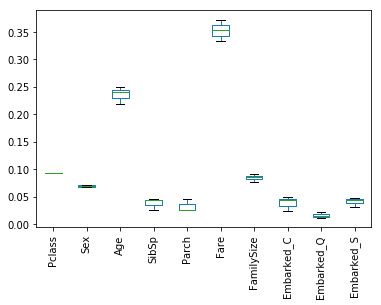

In [7]:
params = study.best_trial.params

def main():
    df_train = pd.read_csv("train.csv")

    train_y = df_train["Survived"]
    train_x = df_train.drop("Survived", axis=1)

    train_x = preprocess_df(train_x)
    accuracies, feature_importances = validate(train_x, train_y, params) # paramsに書き換えました。
    print(np.mean(accuracies))
    plot_feature_importances(feature_importances, train_x.columns)

    flag_product = True
    if flag_product:
        df_test = pd.read_csv("test.csv")
        df_test_raw = df_test.copy()
        test_x = preprocess_df(df_test)
        predict_df(train_x, train_y, test_x, df_test_raw, "result.csv")

if __name__ == "__main__":
    main()

OptunaでチューニングしたパラメーターをKaggleへSubmitすると、精度が0.78468になればOKです。

## アンサンブルによる精度向上

機械学習において、**単一のモデルをそのまま使うのではなく、複数のモデルを組み合わせることで、精度を上げる**手法をアンサンブル学習といいます。

実際のKaggleではアンサンブルによる精度向上がかなり大きく、これだけである程度の順位を取ることができます。

ここでは、機械学習のアルゴリズムを2つ組み合わせて（LightGBMとXGBoost）、精度がよくなるかを見てみます。

 - ソースコード


In [20]:
# 今回はクロスバリデーションで精度を出す以外のところは削っています。
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

# main文
df_train = pd.read_csv("train.csv")
train_y = df_train["Survived"]
train_x = df_train.drop("Survived", axis=1)

train_x = preprocess_df(train_x)

accuracies = []

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for train_idx, test_idx in cv.split(train_x, train_y):
    trn_x = train_x.iloc[train_idx, :]
    val_x = train_x.iloc[test_idx, :]

    trn_y = train_y.iloc[train_idx]
    val_y = train_y.iloc[test_idx]

    clf_xgb = xgb.XGBClassifier(**params)
    clf_lgb = lgb.LGBMClassifier(**params)

    clf_xgb.fit(trn_x, trn_y)
    clf_lgb.fit(trn_x, trn_y)
    
    # 平均値化するためにprobabilityを出した
    pred_proba_y_xgb = clf_xgb.predict_proba(val_x)[:, 1]
    pred_proba_y_lgb = clf_lgb.predict_proba(val_x)[:, 1]
    
    # probabilityの平均値が0.50を超えていれば1, そうでないなら0
    pred_proba_y = pd.DataFrame({"xgb": pred_proba_y_xgb, "lgb": pred_proba_y_lgb}).mean(axis=1)
    pred_y = [1 if proba > 0.50 else 0 for proba in pred_proba_y]
    accuracies.append(accuracy_score(val_y, pred_y))

print(np.mean(accuracies))

0.8215488215488215



今回は精度は下がってしまいました。。

今回は単純に平均値を取っただけですが、実際は複数の判別モデルから出力された値をさらに機械学習に入れ込むStackingなど、

様々な手法が取られています。

## おわりに

機械学習において、特徴量エンジニアリングの方がハイパーパラメーター探索より重要であることが多いです。

ただ、ハイパーパラメーターのチューニングも必要な技術ではあるので、一通りおさらいしました。

ここで概ね機械学習の講座は終わりです。 最後の８章で今後の方針を示します。
